In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input
from datetime import datetime, timedelta


In [ ]:
# Input ticker and download data
ticker = input("Enter the ticker symbol: ").upper() +".NS"
data = yf.download(ticker, period="max", interval="1d")

Enter the ticker symbol: pnb


[*********************100%***********************]  1 of 1 completed


In [ ]:
if data.empty:
    print(f"No data found for ticker: {ticker}")
    exit()


In [ ]:
data


Price,Close,High,Low,Open,Volume
Ticker,PNB.NS,PNB.NS,PNB.NS,PNB.NS,PNB.NS
Date,,,,,
2002-07-01,6.708181,6.827345,6.694163,6.729211,825970
2002-07-02,6.659116,6.778279,6.624068,6.729212,653405
2002-07-03,6.666123,6.708180,6.631075,6.631075,305880
2002-07-04,6.813327,6.939499,6.673135,6.701173,2413155
2002-07-05,6.904452,6.974547,6.729212,6.939499,3460955
...,...,...,...,...,...
2025-01-06,101.739998,106.370003,101.279999,106.370003,44287969
2025-01-07,103.110001,104.589996,102.000000,102.000000,21097404


In [ ]:
data = data[['Close']].dropna()

In [ ]:
print(data.head())

Price          Close
Ticker        PNB.NS
Date                
2002-07-01  6.708181
2002-07-02  6.659116
2002-07-03  6.666123
2002-07-04  6.813327
2002-07-05  6.904452


In [ ]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [ ]:
# Prepare the dataset for LSTM
time_step = 60
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

X_train, y_train, X_test, y_test = [], [], [], []

for i in range(len(train_data) - time_step - 1):
    X_train.append(train_data[i:(i + time_step), 0])
    y_train.append(train_data[i + time_step, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

for i in range(len(test_data) - time_step - 1):
    X_test.append(test_data[i:(i + time_step), 0])
    y_test.append(test_data[i + time_step, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [ ]:
# Build and compile the LSTM model
inputs = Input(shape=(X_train.shape[1], 1))
x = LSTM(50, return_sequences=False)(inputs)
x = Dropout(0.2)(x)
x = Dense(1)(x)

In [ ]:
model = Model(inputs=inputs, outputs=x)
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=1)


Epoch 1/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 0.0647 - val_loss: 4.2560e-04
Epoch 2/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.0027 - val_loss: 2.5777e-04
Epoch 3/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.0024 - val_loss: 2.1349e-04
Epoch 4/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0019 - val_loss: 2.6910e-04
Epoch 5/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0019 - val_loss: 1.7345e-04
Epoch 6/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.0018 - val_loss: 1.7321e-04
Epoch 7/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0016 - val_loss: 2.4466e-04
Epoch 8/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.0017 - val_loss: 1.5372e-04
Epoch 9/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0016 - val_loss: 3.2740e-04
Epoch 10/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0016 - val_loss: 2.3468e-04


In [ ]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
train_mse = mean_squared_error(y_train_actual, train_predict)
test_mse = mean_squared_error(y_test_actual, test_predict)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
train_mae = mean_absolute_error(y_train_actual, train_predict)
test_mae = mean_absolute_error(y_test_actual, test_predict)
train_r2 = r2_score(y_train_actual, train_predict)
test_r2 = r2_score(y_test_actual, test_predict)

# Print Evaluation Metrics
print("Evaluation Metrics:")
print(f"Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}")
print(f"Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")
print(f"Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}")
print(f"Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}")


138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Evaluation Metrics:
Train MSE: 35.3929, Test MSE: 12.1157
Train RMSE: 5.9492, Test RMSE: 3.4808
Train MAE: 4.3436, Test MAE: 2.5685
Train R²: 0.9869, Test R²: 0.9890


In [ ]:
# Predict future prices
future_days = 180
future_predictions = []
current_input = scaled_data[-time_step:].reshape(1, time_step, 1)

for _ in range(future_days):
    predicted_price = model.predict(current_input)
    future_predictions.append(predicted_price[0, 0])
    current_input = np.append(current_input[:, 1:, :], predicted_price.reshape(1, 1, 1), axis=1)

future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Determine trend
x = np.arange(len(future_predictions))
slope, _ = np.polyfit(x, future_predictions.flatten(), 1)
future_trend = "Upward" if slope > 0 else "Downward" if slope < 0 else "Sideways"
print(f"Predicted Future Trend: {future_trend}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

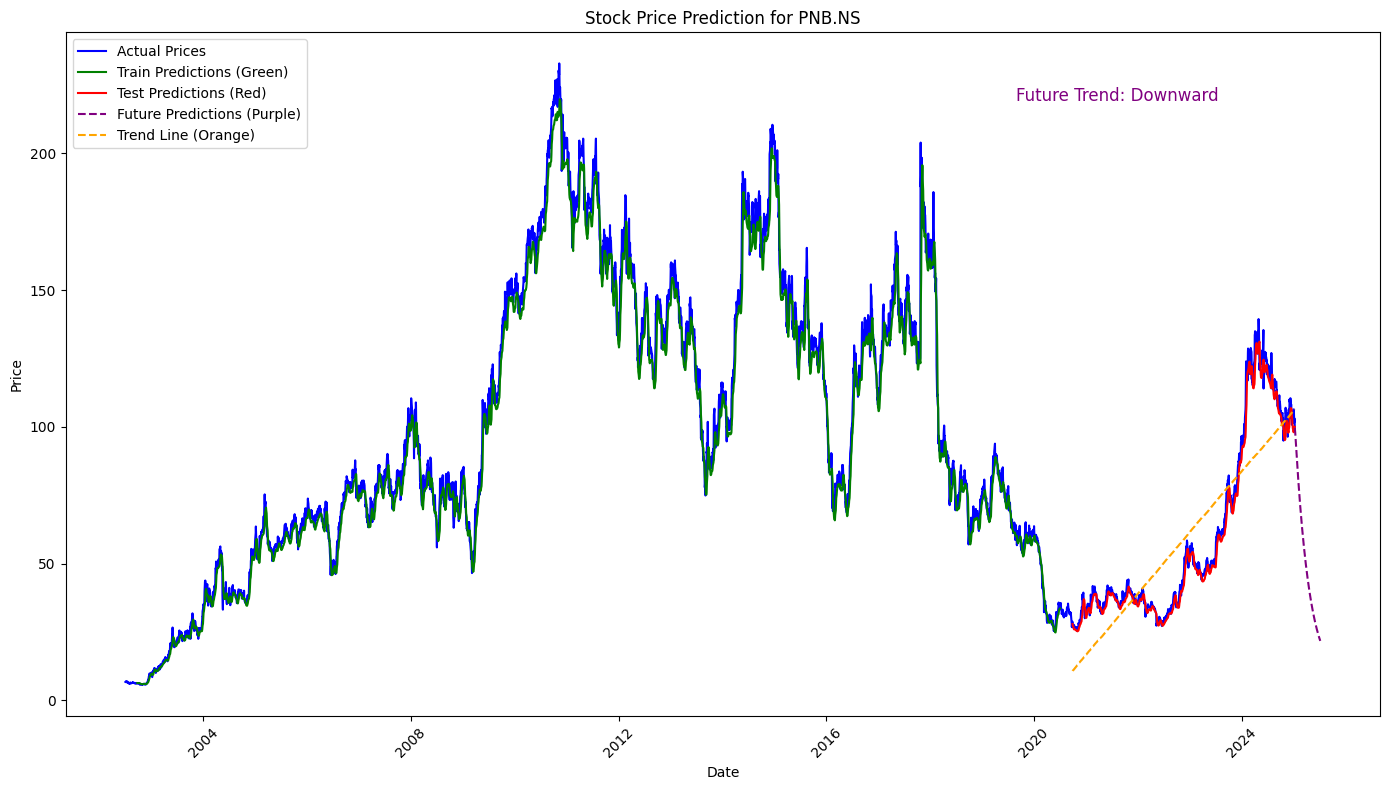

In [ ]:
# Plot results
plt.figure(figsize=(14, 8))
plt.plot(data.index, scaler.inverse_transform(scaled_data), label="Actual Prices", color="blue")
train_idx = data.index[time_step:len(train_predict) + time_step]
plt.plot(train_idx, train_predict, label="Train Predictions (Green)", color="green")
test_idx = data.index[len(train_data) + time_step:len(train_data) + time_step + len(test_predict)]
plt.plot(test_idx, test_predict.flatten(), label="Test Predictions (Red)", color="red")
future_dates = pd.date_range(test_idx[-1] + timedelta(days=1), periods=future_days)
plt.plot(future_dates, future_predictions, label="Future Predictions (Purple)", color="purple", linestyle="dashed")

# Trend line for test predictions
test_trend = np.polyval(np.polyfit(np.arange(len(test_predict.flatten())), test_predict.flatten(), 1), np.arange(len(test_predict.flatten())))
plt.plot(test_idx, test_trend, label="Trend Line (Orange)", color="orange", linestyle="--")

# Annotate the trend
plt.annotate(f"Future Trend: {future_trend}",
             xy=(0.8, 0.9), xycoords='axes fraction',
             fontsize=12, color='purple', ha='center')

plt.title(f"Stock Price Prediction for {ticker}")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()